In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, NuSVC
from sklearn.mixture import GaussianMixture
from sklearn import linear_model, ensemble
from scipy.signal import find_peaks_cwt
from FeatureAnalysis import RescalePCA, HistFeature, FFTFeature
from DataProcessing import ToPandasData, DataCombiner, DataAugmentor
from DataVisulization import VisCompareTwoPCA, VisMeasurements, VisFFTResult, VisTrainVsTest, VisPredResult
import random
import time

In [2]:
DATA_COMBINER = DataCombiner()
# convert all trial data and to be ready to pass in to the PCA 
# structure: {gait_type:{trial_name: total_trial_num}}
All_gait_trials = {'normal': ('Normal', 5), 'normal_2': ('Normal',5), 'ran_2': ('Normal',5), 'normal_3':('Normal', 6),
                   'side':('Side Walk', 5), 'side_2':('Side Walk', 5),'ran_side':('Side Walk', 5),
                   'inward_01': ('Inward', 5),
                   'line_01':('Line', 5)}

In [3]:
DATA_COMBINER.loadTrialData(All_gait_trials, '../Data_Collection/','.txt')
All_combined_data = DATA_COMBINER.combineAllData()
gait_types = DATA_COMBINER.label_order
DATA_AUG = DataAugmentor(All_combined_data)
aug_all_types = DATA_AUG.all_types

Start Loading: From txt files into Pandas
Finish Loading: Time taken 1.72 sec

Start Combining: Combine specific type trials under each general type
Finish Combining: Time taken 0.046 sec



In [4]:
All_aug_data = DATA_AUG.subSampleAll(out_length=5000, num_draw=500, std_percentile= 20)

Start Data Augmentation: subsample data from combined data and add noise
Finish Augmenting Data: Normal, Time Taken 3.545 sec
Finish Augmenting Data: Side Walk, Time Taken 3.524 sec
Finish Augmenting Data: Inward, Time Taken 3.523 sec
Finish Augmenting Data: Line, Time Taken 3.508 sec
Finish All Data Augmentation, Time Taken: 14.1 sec



In [5]:
# put all raw trials into a single df to apply PCA
list_all_raw_data = []
for each_gen in All_combined_data:
    for each_spec in All_combined_data[each_gen]:
        list_all_raw_data.append(All_combined_data[each_gen][each_spec])
all_trial_df = pd.concat(list_all_raw_data)

PCA_all = RescalePCA()
reduced_dim = 3
PCA_all.processRescalePCA(all_trial_df, reduced_dim)
print(PCA_all)

PCA Info: 
[0.37801026 0.31405233 0.13084784]
Rescale Info:
Voltage_01: (1.0, 0.0)
Voltage_02: (1.0, 0.0)
Acc_x: (42.93, -78.47)
Acc_y: (42.04, -78.47)
Acc_z: (78.47, -29.72)
Gyro_x: (4.28, -4.28)
Gyro_y: (4.28, -4.28)
Gyro_z: (4.28, -4.28)
Component Range: 
[-0.65 -0.56 -0.51]
[0.7  0.82 0.61]
Feature Order: {'Voltage_01': 0, 'Voltage_02': 1, 'Acc_x': 2, 'Acc_y': 3, 'Acc_z': 4, 'Gyro_x': 5, 'Gyro_y': 6, 'Gyro_z': 7}


In [6]:
num_hist_bins = 20
num_fft_features = 10
cut_off = 100
def GetAllFeatures(pca_data, component_range, num_hist_bins,
                   time_data, cut_off, num_fft_bins):
    return np.hstack((HistFeature(pca_data, component_range, num_hist_bins), 
                                         FFTFeature(pca_data,sample['Time'], cut_off, num_fft_bins)))

In [7]:
# combine all the trials data into HistFeatures and combined into a matrix for modeling training 
# buffer the feature matrix and label array
num_train_samples = sum([len(All_aug_data[each_type]) for each_type in All_aug_data])
train_matrix = np.zeros((num_train_samples, reduced_dim * num_hist_bins + reduced_dim * num_fft_features))
train_labels = np.zeros(num_train_samples)
# process each sample for the hist features
idx = 0
print('Strat Feature Extraction: ')
for each_type in All_aug_data:
    cur_ini_time = time.time()
    cur_samples = All_aug_data[each_type]
    cur_type_idx = gait_types.index(each_type)
    for sample in cur_samples:
        cur_pca = PCA_all.applyRescalePCA(sample)
        train_matrix[idx,:] = GetAllFeatures(cur_pca, PCA_all.component_range, num_hist_bins,
                                            sample['Time'], cut_off, num_fft_features)
        train_labels[idx] = cur_type_idx
        idx += 1
    print(each_type + " Completed: Time Taken: " + str(round(time.time() - cur_ini_time, 3)) + ' sec ...')
print('All Feature Extractions Completed, Ready to Train Model')

Strat Feature Extraction: 
Normal Completed: Time Taken: 2.718 sec ...
Side Walk Completed: Time Taken: 2.696 sec ...
Inward Completed: Time Taken: 2.691 sec ...
Line Completed: Time Taken: 2.677 sec ...
All Feature Extractions Completed, Ready to Train Model


In [16]:
log_ini_time = time.time()
# Test if logistc regrisson works 
test_log = linear_model.LogisticRegression()
test_log.fit(train_matrix, train_labels)
print('Logistic Regression Model Trained, Time Taken: ' + str(round(time.time() - log_ini_time, 3)) + ' sec')

svm_ini_time = time.time()
# Support vector machine  
test_svc = NuSVC(probability=True, gamma=1/1000, kernel='linear')
test_svc.fit(train_matrix, train_labels)
print('SVM Model Trained, Time Taken: ' + str(round(time.time() - svm_ini_time, 3)) + ' sec')

gbt_ini_time = time.time()
# Gradient Boosting Ensemble
test_gbt = ensemble.GradientBoostingClassifier()
test_gbt.fit(train_matrix, train_labels)
print('GBT Model Trained, Time Taken: ' + str(round(time.time() - gbt_ini_time, 3)) + ' sec')

Logistic Regression Model Trained, Time Taken: 0.052 sec
SVM Model Trained, Time Taken: 1.599 sec
GBT Model Trained, Time Taken: 1.231 sec


In [17]:
def ReadDataForTest(trial_name, PCA_process_obj, num_hist_bins, cut_off, num_fft_features):
    test_case = ToPandasData('../Data_Collection/' + trial_name + '.txt')
    test_in = PCA_all.applyRescalePCA(test_case)
    test_fea = GetAllFeatures(test_in, PCA_process_obj.component_range, num_hist_bins, 
                             test_case['Time'], cut_off, num_fft_features)
    return {'Trial_Name': trial_name,
            'Raw Data': test_case, 
            'PCA Data': test_in, 
            'Features': test_fea}

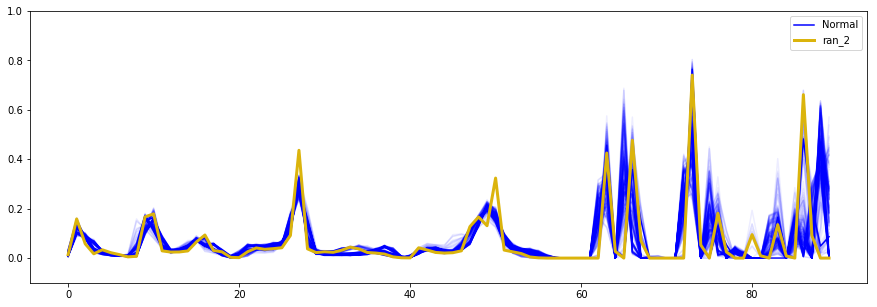

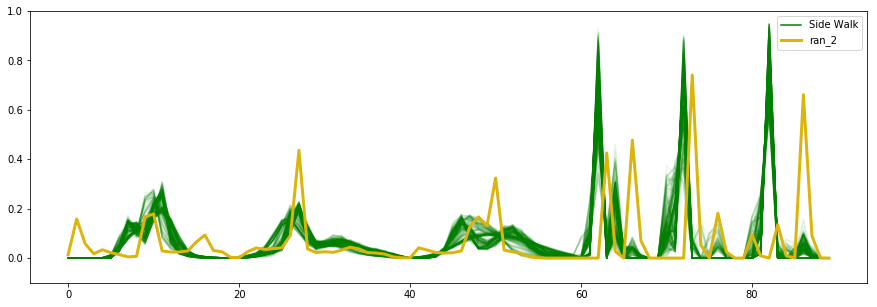

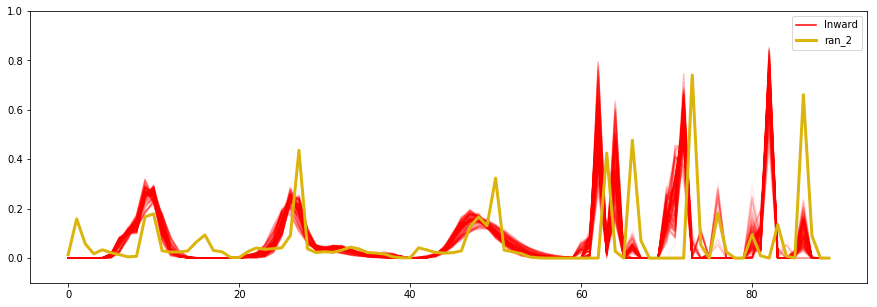

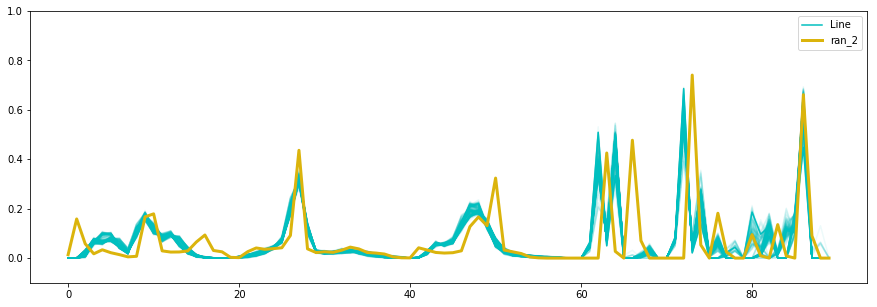

In [18]:
all_test_data = []
test_trials_type = 'ran_2'
for idx in range(1,6):
    cur_case_name = test_trials_type + '_0' + str(idx)
    cur_test_case = ReadDataForTest(cur_case_name, PCA_all, num_hist_bins, cut_off, num_fft_features)
    all_test_data.append(cur_test_case)
    
VisTrainVsTest(train_matrix, train_labels, gait_types, all_test_data[4]['Features'], test_trials_type)

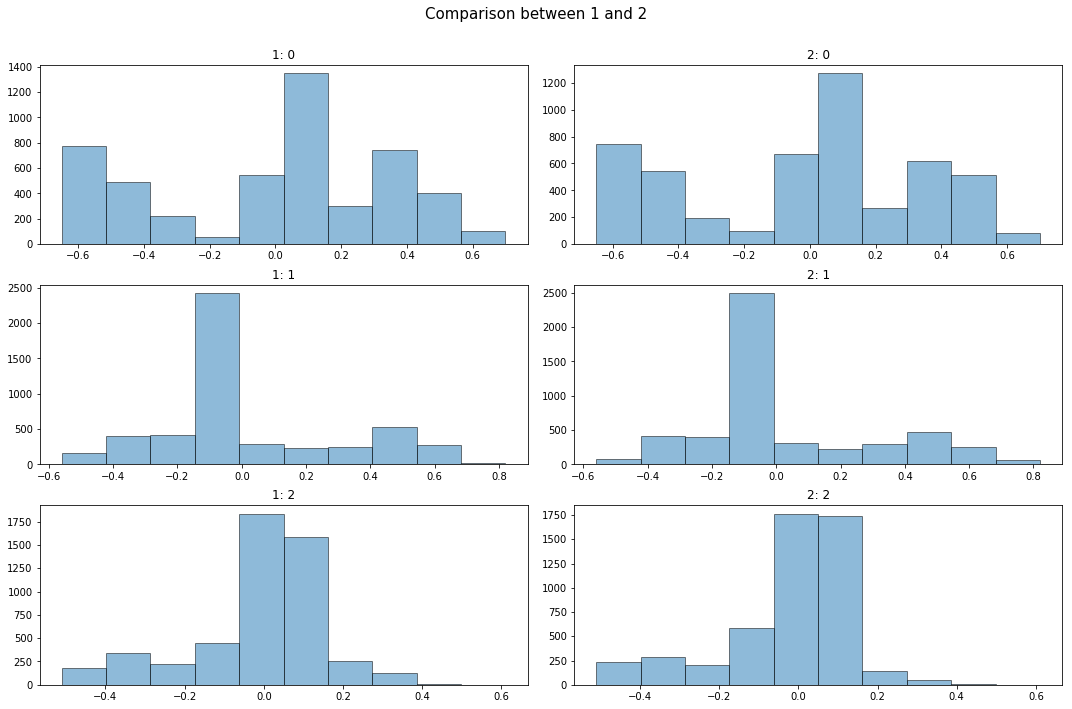

In [19]:
VisCompareTwoPCA(all_test_data[0]['PCA Data'], all_test_data[1]['PCA Data'], PCA_all, '1','2')

Log


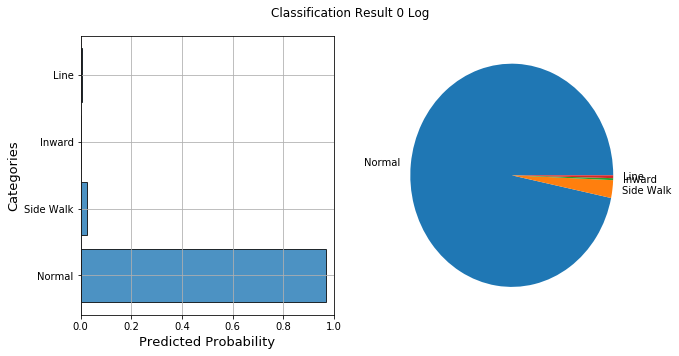

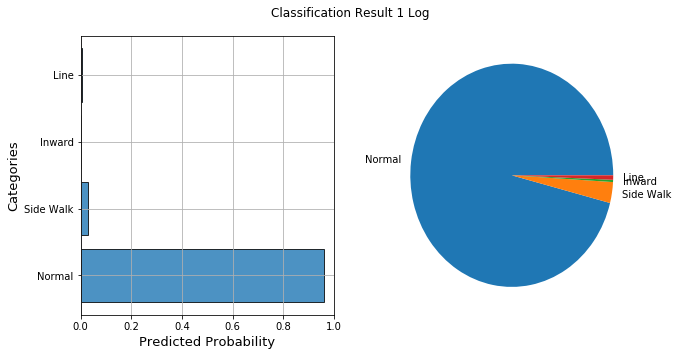

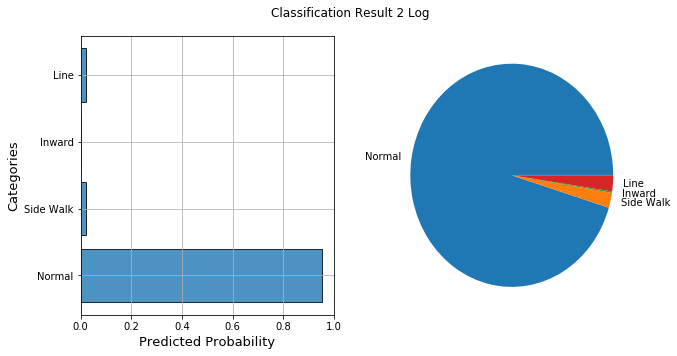

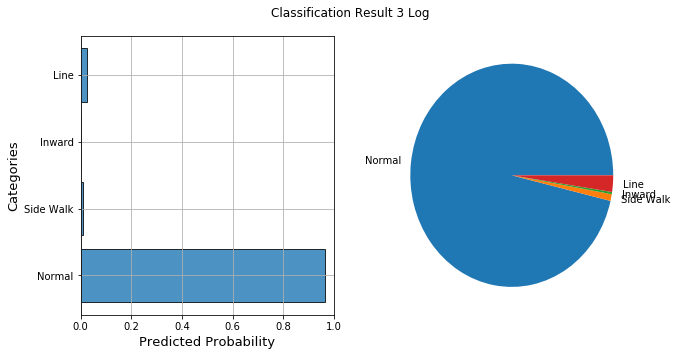

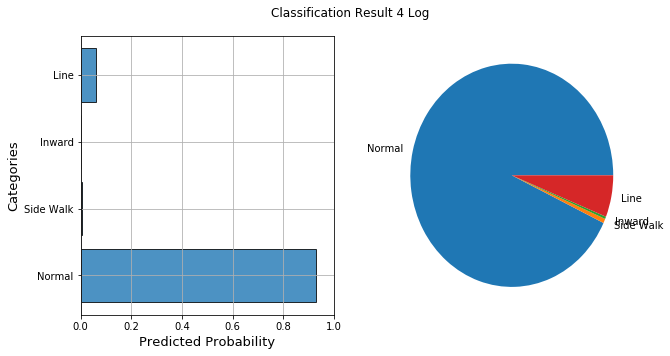

In [20]:
print('Log')
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_log.predict_proba([cur_test_fea])[0], gait_types, str(idx) + ' ' + "Log")

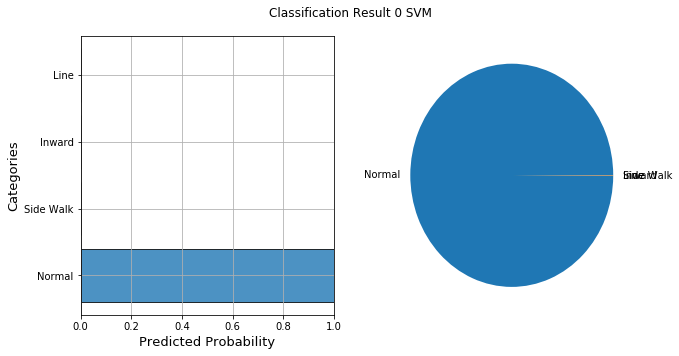

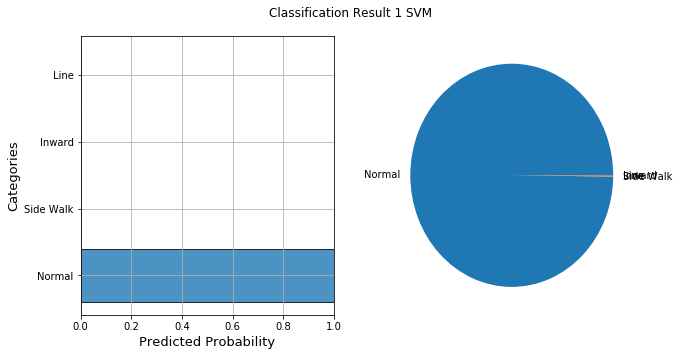

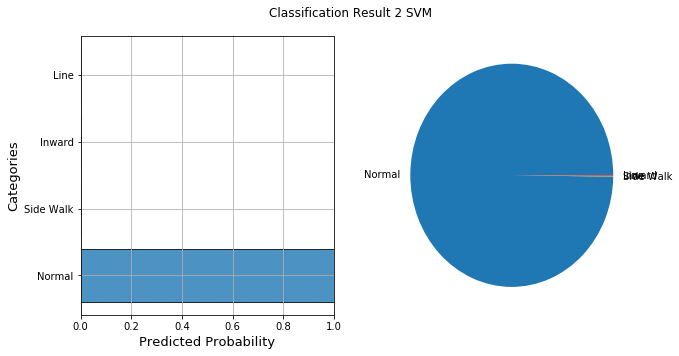

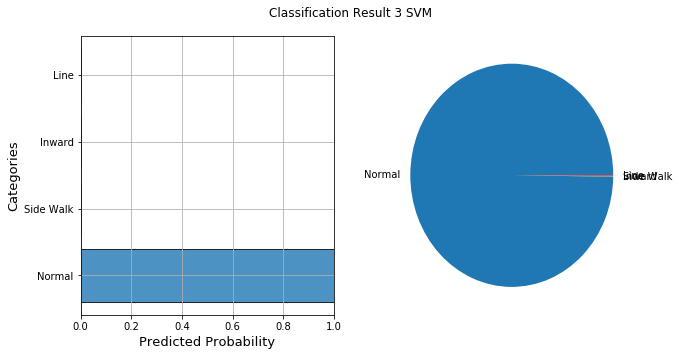

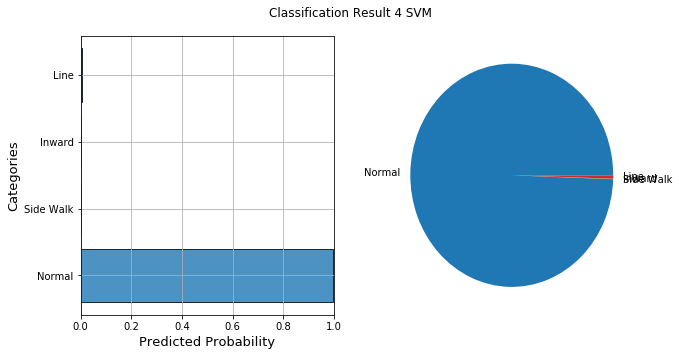

In [21]:
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_svc.predict_proba([cur_test_fea])[0], gait_types, str(idx) + ' ' + "SVM")
    

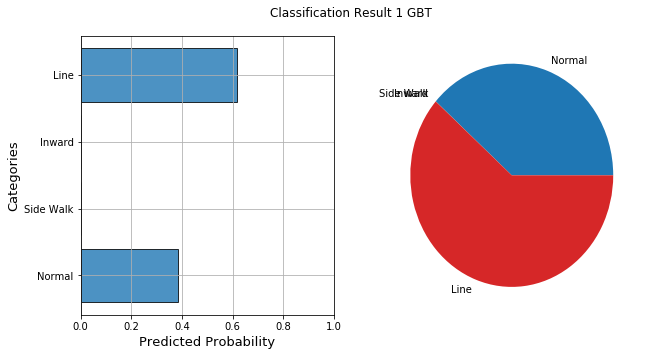

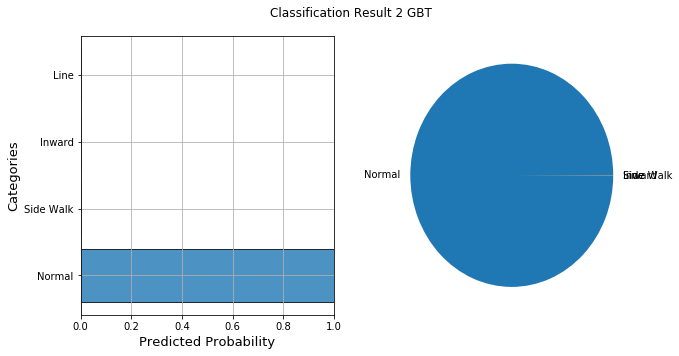

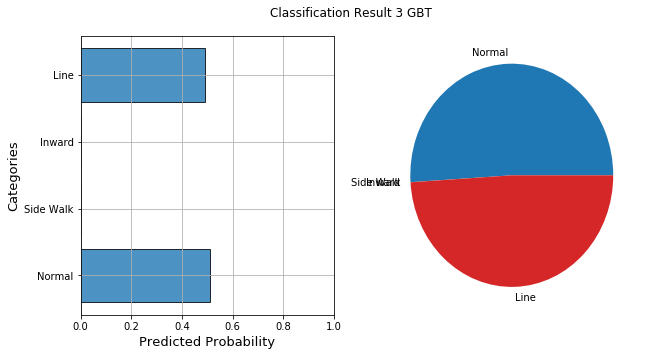

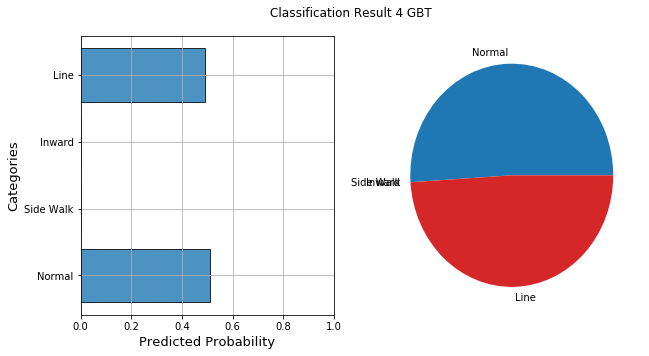

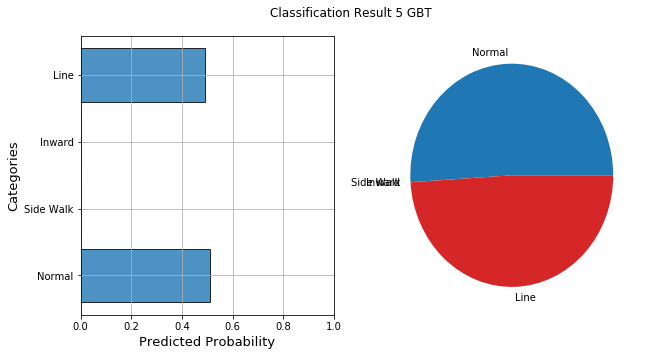

In [22]:
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_gbt.predict_proba([cur_test_fea])[0], gait_types, str(idx+1) + ' ' + "GBT")